<a href="https://colab.research.google.com/github/nmningmei/Deep_learning_fMRI_EEG/blob/master/8_3_extract_representations_from_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the [Caltech101 images](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) for fine-tuning.

## I don't recommend to fine-tune any networks on the experimental stimuli because such procedure would introduce artificial biases towards to the experiment and limit the generalizability to the wider range of conclusions and interpretations. 

In [0]:
!wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz

--2019-11-17 16:55:07--  http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131740031 (126M) [application/x-tar]
Saving to: ‘101_ObjectCategories.tar.gz’

101_ObjectCategorie 100%[===================>] 125.64M  8.87MB/s    in 15s     

2019-11-17 16:55:22 (8.50 MB/s) - ‘101_ObjectCategories.tar.gz’ saved [131740031/131740031]



In [0]:
 !tar -zxvf 101_ObjectCategories.tar.gz
 !rm 101_ObjectCategories.tar.gz

101_ObjectCategories/
101_ObjectCategories/BACKGROUND_Google/
101_ObjectCategories/BACKGROUND_Google/tmp
101_ObjectCategories/BACKGROUND_Google/image_0004.jpg
101_ObjectCategories/BACKGROUND_Google/image_0005.jpg
101_ObjectCategories/BACKGROUND_Google/image_0006.jpg
101_ObjectCategories/BACKGROUND_Google/image_0007.jpg
101_ObjectCategories/BACKGROUND_Google/image_0008.jpg
101_ObjectCategories/BACKGROUND_Google/image_0010.jpg
101_ObjectCategories/BACKGROUND_Google/image_0011.jpg
101_ObjectCategories/BACKGROUND_Google/image_0012.jpg
101_ObjectCategories/BACKGROUND_Google/image_0013.jpg
101_ObjectCategories/BACKGROUND_Google/image_0014.jpg
101_ObjectCategories/BACKGROUND_Google/image_0016.jpg
101_ObjectCategories/BACKGROUND_Google/image_0017.jpg
101_ObjectCategories/BACKGROUND_Google/image_0002.jpg
101_ObjectCategories/BACKGROUND_Google/image_0018.jpg
101_ObjectCategories/BACKGROUND_Google/image_0019.jpg
101_ObjectCategories/BACKGROUND_Google/image_0021.jpg
101_ObjectCategories/BACKGROUND

## remove 'BACKGROUND Google', 'Faces', 'Faces easy', 'brain', 'stop sign', and 'trilobite' categories

In [0]:
!rm -r "101_ObjectCategories/BACKGROUND_Google"
!rm -r "101_ObjectCategories/Faces"
!rm -r "101_ObjectCategories/Faces_easy"
!rm -r "101_ObjectCategories/brain"
!rm -r "101_ObjectCategories/stop_sign"
!rm -r "101_ObjectCategories/trilobite"

In [0]:
ls 101_ObjectCategories

accordion/     cougar_face/      gramophone/    metronome/   snoopy/
airplanes/     crab/             grand_piano/   minaret/     soccer_ball/
anchor/        crayfish/         hawksbill/     Motorbikes/  stapler/
ant/           crocodile/        headphone/     nautilus/    starfish/
barrel/        crocodile_head/   hedgehog/      octopus/     stegosaurus/
bass/          cup/              helicopter/    okapi/       strawberry/
beaver/        dalmatian/        ibis/          pagoda/      sunflower/
binocular/     dollar_bill/      inline_skate/  panda/       tick/
bonsai/        dolphin/          joshua_tree/   pigeon/      umbrella/
brontosaurus/  dragonfly/        kangaroo/      pizza/       watch/
buddha/        electric_guitar/  ketch/         platypus/    water_lilly/
butterfly/     elephant/         lamp/          pyramid/     wheelchair/
camera/        emu/              laptop/        revolver/    wild_cat/
cannon/        euphonium/        Leopards/      rhino/       windsor_chai

# Get the images we want to extract representations from

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
figures_id = 'https://drive.google.com/open?id=1CHr3XOwpMORsEvvDN5pYhYpAYQYU69Bo'.split('id=')[-1]
downloaded = drive.CreateFile({'id':figures_id})
downloaded.GetContentFile(f'greyscaled.zip')

figures_id = 'https://drive.google.com/open?id=1xN0fkx8E4VUERPHrbDiFKS34GHZ_dOgI'.split('id=')[-1]
downloaded = drive.CreateFile({'id':figures_id})
downloaded.GetContentFile(f'greyscaled_sub.zip')

In [0]:
import zipfile
for f in ['greyscaled.zip','greyscaled_sub.zip']:
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall(f'{f.split(".")[0]}')

In [0]:
!rm greyscaled.zip
!rm greyscaled_sub.zip

# Fine-tune one of the many computer vision models on the caltech 101 dataset

## Preparing

In [0]:
!pip install --upgrade tensorflow-gpu

In [0]:
import tensorflow as tf
print(f'tensorflow {tf.__version__}')
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (DenseNet169, # to load the pre-train convolutional neural network
                                           densenet     # to load the preprocessing function when training the CNN
                                           )
from tensorflow.keras import layers,models,optimizers,losses,regularizers

import numpy as np
import pandas as pd

from scipy.spatial import distance

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
sns.set_style('white')
sns.set_context('paper')

tensorflow 2.0.0


In [0]:
resize_image = 128
batch_size = 32
epochs = 1000

In [0]:
# the most important helper function: early stopping and model saving
def make_CallBackList(model_name,monitor='val_loss',mode='min',verbose=0,min_delta=1e-4,patience=50,frequency = 1):
    from tensorflow.keras.callbacks             import ModelCheckpoint,EarlyStopping
    """
    Make call back function lists for the keras models
    
    Inputs
    -------------------------
    model_name: directory of where we want to save the model and its name
    monitor:    the criterion we used for saving or stopping the model
    mode:       min --> lower the better, max --> higher the better
    verboser:   printout the monitoring messages
    min_delta:  minimum change for early stopping
    patience:   temporal windows of the minimum change monitoring
    frequency:  temporal window steps of the minimum change monitoring
    
    Return
    --------------------------
    CheckPoint:     saving the best model
    EarlyStopping:  early stoppi
    """
    checkPoint = ModelCheckpoint(model_name,# saving path
                                 monitor          = monitor,# saving criterion
                                 save_best_only   = True,# save only the best model
                                 mode             = mode,# saving criterion
#                                 save_freq        = 'epoch',# frequency of check the update 
                                 verbose          = verbose,# print out (>1) or not (0)
                                 )
    earlyStop = EarlyStopping(   monitor          = monitor,
                                 min_delta        = min_delta,
                                 patience         = patience,
                                 verbose          = verbose, 
                                 mode             = mode,
                                 )
    return [checkPoint,earlyStop]

In [0]:
pretrained_model = DenseNet169(include_top = False,                             # not to include the fully connected layers
                               weights = 'imagenet',                            # get the pre-trained weights
                               input_tensor = None,                             # doesn't matter
                               input_shape = (resize_image,resize_image,3),     # define the input-shape, otherwise, defult being 224 x 224 x 3
                               pooling = 'avg',                                 # the pooling of the last convolutional layer: why average or why max?
                               classes = 1000,                                  # doesn't matter
                               )
preprcessing_funcs = densenet.preprocess_input

## Before fine-tuning, let's look at the representations of the experimental images

In [0]:
static_gen = ImageDataGenerator(preprocessing_function=preprcessing_funcs,)
gen = static_gen.flow_from_directory('greyscaled/greyscaled',
                                     target_size       = (resize_image,resize_image),  # resize the image
                                     batch_size        = batch_size,                   # batch size
                                     class_mode        = 'categorical',                # get the labels from the folders
                                     shuffle           = False,                        # shuffle for different epochs
                                     seed              = 12345,                        # replication purpose
                                     follow_links      = True, 
                                     )

Found 2592 images belonging to 2 classes.


In [0]:
preds = pretrained_model.predict_generator(gen,steps = np.ceil(gen.n / batch_size),verbose = 1)

81/81 [==============================] - 19s 234ms/step


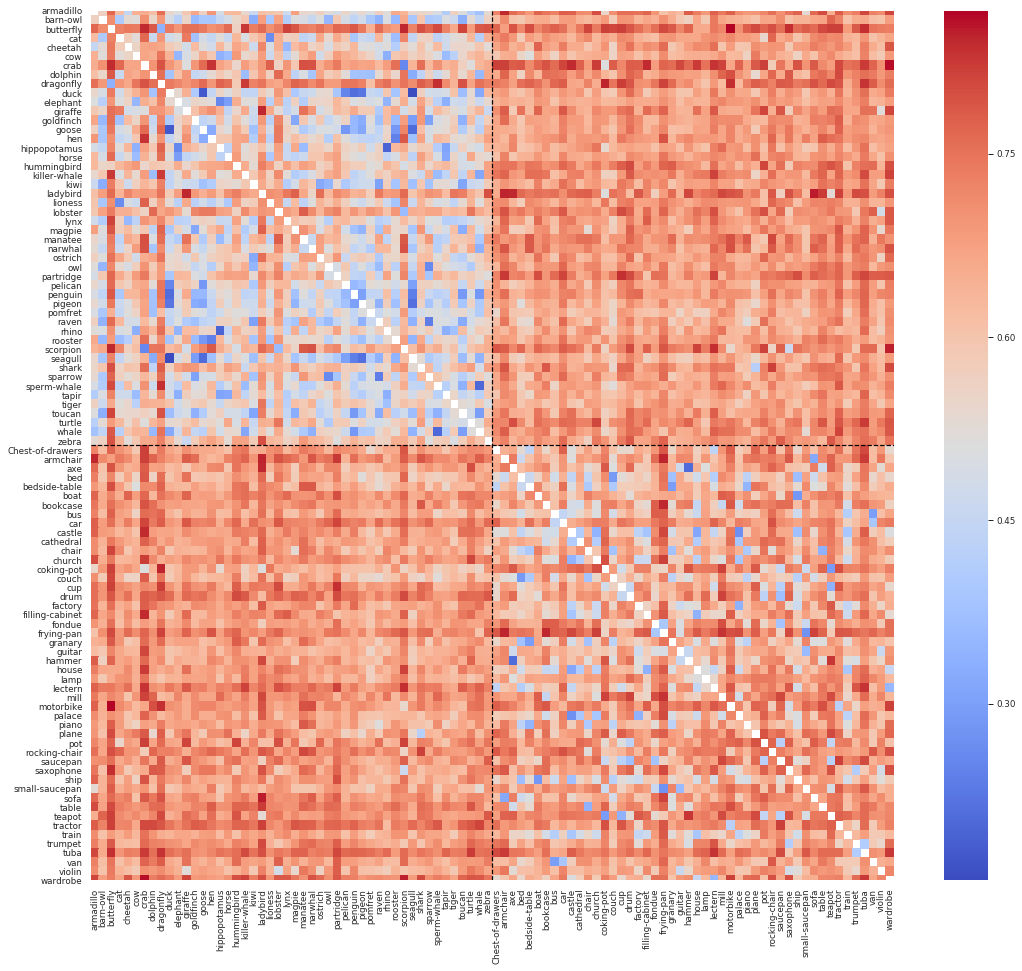

In [0]:
df_plot = pd.DataFrame(preds,columns = [f'feature_{ii + 1}' for ii in range(preds.shape[1])])
df_plot['sub_class'] = np.array([item.split('/')[0] for item in gen.filenames])
df_plot['unique_class'] = np.array([item.split('/')[-1].split('_')[0] for item in gen.filenames])
df_plot['target'] = gen.classes
df = df_plot.groupby(['unique_class','sub_class','target']).mean().reset_index()
df = df.sort_values(['target','sub_class',])
labels = df['unique_class'].values
features = df.iloc[:,3:].values
RDM = distance.squareform(distance.pdist(features - features.mean(1).reshape(-1,1),
                                         'cosine'))
RDM_filled = RDM.copy()
np.fill_diagonal(RDM_filled,np.nan)
df_rdm = pd.DataFrame(RDM_filled,index = labels, columns = labels)
fig,ax = plt.subplots(figsize = (18,16))
ax = sns.heatmap(df_rdm,
                 cmap = plt.cm.coolwarm,
                 xticklabels = True,
                 yticklabels = True)
ax.axhline(96 / 2, linestyle = '--', color = 'black', alpha = 1.)
ax.axvline(96 / 2, linestyle = '--', color = 'black', alpha = 1.)

# Fine-tuning the pre-trained model with caltech 101 data

## Define the data flow

In [0]:
gen = ImageDataGenerator(rotation_range         = 90,                     # allow rotation
                         width_shift_range      = 0.1,                    # horizontal schetch
                         height_shift_range     = 0.1,                    # vertical schetch
                         zoom_range             = 0.1,                    # zoom in
                         horizontal_flip        = True,                   # 
                         vertical_flip          = True,                   # 
                         preprocessing_function = preprcessing_funcs,     # preprocessing function
                         validation_split       = 0.2,
                         )
gen_train = gen.flow_from_directory('101_ObjectCategories',
                                     #color_mode        = 'grayscale',                  # grayscale the colored images 
                                     target_size       = (resize_image,resize_image),  # resize the image
                                     batch_size        = batch_size,                   # batch size
                                     class_mode        = 'categorical',                # get the labels from the folders
                                     shuffle           = True,                         # shuffle for different epochs
                                     seed              = 12345,                        # replication purpose
                                     subset            = 'training',                   # name them "training"
                                     )
gen_validation = gen.flow_from_directory('101_ObjectCategories',
                                     #color_mode        = 'grayscale',                  # grayscale the colored images 
                                     target_size       = (resize_image,resize_image),  # resize the image
                                     batch_size        = batch_size,                   # batch size
                                     class_mode        = 'categorical',                # get the labels from the folders
                                     shuffle           = True,                         # shuffle for different epochs
                                     seed              = 12345,                        # replication purpose
                                     subset            = 'validation',                 # name them "validation"
                                     )

Found 6086 images belonging to 96 classes.
Found 1473 images belonging to 96 classes.


## Add layers to the pre-trained model.

### What we care is the very next layer that connects the last convolutional neural net, while the prediction layer is for fitting and nothing else

In [0]:
pretrained_model.trainable = False
for layer in pretrained_model.layers:
    layer.trainable = False
print(pretrained_model.summary())
tf.random.set_seed(12345)
inputs = pretrained_model.inputs
embeddings = layers.Dense(300,
                          activation                       = tf.keras.activations.selu, # SOTA activation function
                          kernel_initializer               = 'lecun_normal', # seggested in documentation
                          kernel_regularizer               = regularizers.l2(),
                          #activity_regularizer             = regularizers.l1(),
                          name                             = 'feature',
                          )(pretrained_model.output)
predicting_layer = layers.Dense(len(gen_train.class_indices),
                                activation                       = 'softmax',
                                #kernel_regularizer               = regularizers.l2(),
                                activity_regularizer             = regularizers.l1(),
                                name                             = 'predict',
                                )(embeddings)
fine_tune_model = models.Model(inputs,predicting_layer,name = 'fine_tune')
print(fine_tune_model.summary())

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

## Don't forget to compile your model and define a stop-check-point for the model

In [0]:
fine_tune_model.compile(optimizers.Adam(lr = 1e-4,),
                        losses.binary_crossentropy,
                        metrics = ['categorical_accuracy'])
callbacks           = make_CallBackList('fine_tune_model.h5',
                                        monitor                 = 'val_{}'.format(fine_tune_model.metrics_names[-1]), # determine the fine tuning by either loss or accuracy
                                        mode                    = 'max',        # direction of determination
                                        verbose                 = 0,            # whether to print the callbacks
                                        min_delta               = 1e-4,         # minimum difference to consider as significant chance
                                        patience                = 2,            # how many cycle of going through the data without gaining significant chance before terminating the fitting
                                        frequency               = 1,            # freqeuncy to check the check points
                                        )

## Start the fine-tuning

In [0]:
fine_tune_model.fit_generator(gen_train,
                          steps_per_epoch                           = np.ceil(gen_train.n / batch_size),
                          epochs                                    = epochs, 
                          validation_data                           = gen_validation,
                          callbacks                                 = callbacks,
                          )
fine_tune_model.load_weights('fine_tune_model.h5')

Epoch 1/1000
191/191 [==============================] - 177s 927ms/step - loss: 1.7749 - categorical_accuracy: 0.2006 - val_loss: 0.8987 - val_categorical_accuracy: 0.2301
Epoch 2/1000
191/191 [==============================] - 177s 927ms/step - loss: 0.5223 - categorical_accuracy: 0.3124 - val_loss: 0.2716 - val_categorical_accuracy: 0.3150
Epoch 3/1000
191/191 [==============================] - 177s 928ms/step - loss: 0.1700 - categorical_accuracy: 0.3761 - val_loss: 0.0988 - val_categorical_accuracy: 0.4277
Epoch 4/1000
191/191 [==============================] - 176s 923ms/step - loss: 0.0787 - categorical_accuracy: 0.4167 - val_loss: 0.0586 - val_categorical_accuracy: 0.3999
Epoch 5/1000
191/191 [==============================] - 178s 930ms/step - loss: 0.0575 - categorical_accuracy: 0.4463 - val_loss: 0.0495 - val_categorical_accuracy: 0.4589
Epoch 6/1000
191/191 [==============================] - 177s 925ms/step - loss: 0.0531 - categorical_accuracy: 0.4594 - val_loss: 0.0483 - v

In [0]:
feature_extractor = models.Model(fine_tune_model.inputs,fine_tune_model.get_layer('feature').output)

In [0]:
static_gen = ImageDataGenerator(preprocessing_function=preprcessing_funcs,)
gen = static_gen.flow_from_directory('greyscaled/greyscaled',
                                     target_size       = (resize_image,resize_image),  # resize the image
                                     batch_size        = batch_size,                   # batch size
                                     class_mode        = 'categorical',                # get the labels from the folders
                                     shuffle           = False,                        # shuffle for different epochs
                                     seed              = 12345,                        # replication purpose
                                     follow_links      = True, 
                                     )

Found 2592 images belonging to 2 classes.


In [0]:
preds = feature_extractor.predict_generator(gen,steps = np.ceil(gen.n / batch_size),verbose = 1)

81/81 [==============================] - 17s 209ms/step


## Plot the RDM after fine-tuning

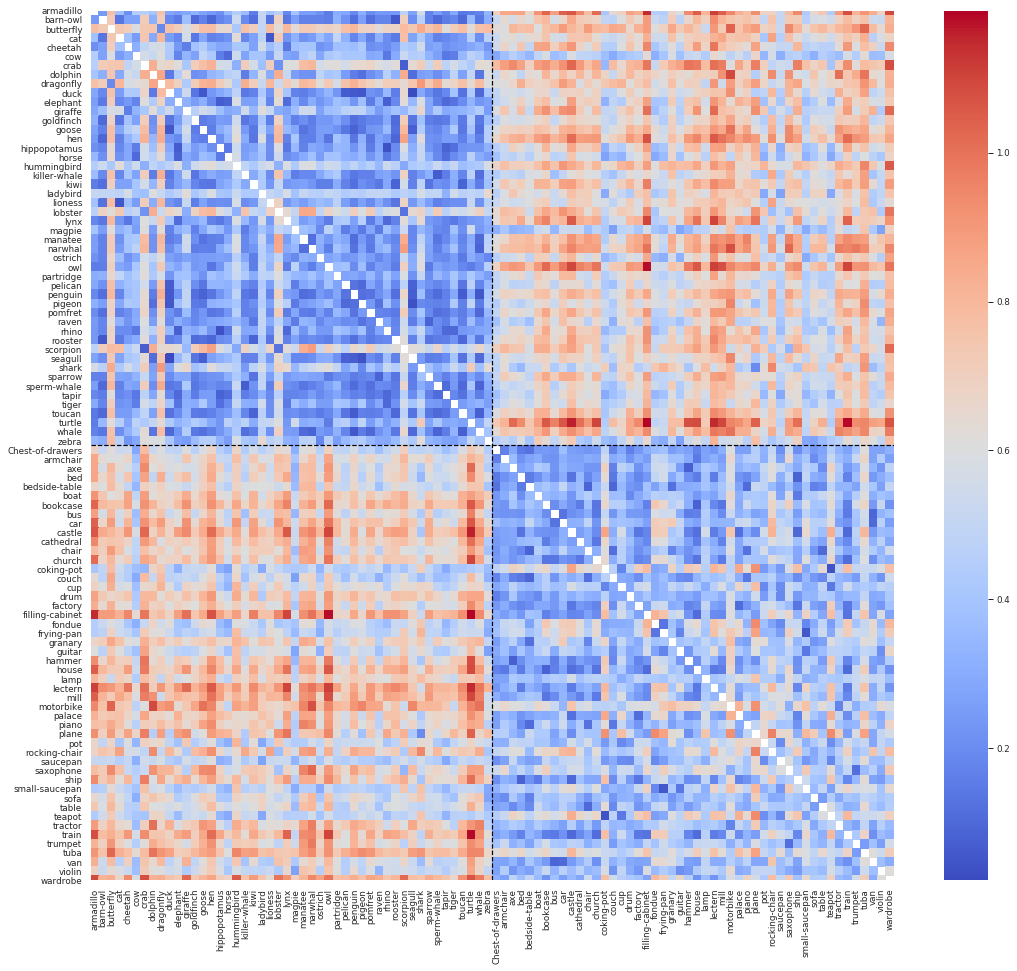

In [0]:
df_plot = pd.DataFrame(preds,columns = [f'feature_{ii + 1}' for ii in range(preds.shape[1])])
df_plot['sub_class'] = np.array([item.split('/')[0] for item in gen.filenames])
df_plot['unique_class'] = np.array([item.split('/')[-1].split('_')[0] for item in gen.filenames])
df_plot['target'] = gen.classes
df = df_plot.groupby(['unique_class','sub_class','target']).mean().reset_index()
df = df.sort_values(['target','sub_class',])
labels = df['unique_class'].values
features = df.iloc[:,3:].values
RDM = distance.squareform(distance.pdist(features - features.mean(1).reshape(-1,1),
                                         'cosine'))
RDM_filled = RDM.copy()
np.fill_diagonal(RDM_filled,np.nan)
df_rdm = pd.DataFrame(RDM_filled,index = labels, columns = labels)
fig,ax = plt.subplots(figsize = (18,16))
ax = sns.heatmap(df_rdm,
                 cmap = plt.cm.coolwarm,
                 xticklabels = True,
                 yticklabels = True)
ax.axhline(96 / 2, linestyle = '--', color = 'black', alpha = 1.)
ax.axvline(96 / 2, linestyle = '--', color = 'black', alpha = 1.)

# Fit an encoding model to predict the BOLD signals given the images

In [0]:
BOLD_id = 'https://drive.google.com/open?id=1R1Y2o_ZrRXrXQ7nBKJa_MjClmk23QWi4'.split('id=')[-1]
downloaded = drive.CreateFile({'id':BOLD_id})
downloaded.GetContentFile(f'lh-fusiform_BOLD.npy')

event_id = 'https://drive.google.com/open?id=1m78-iRuOIQKhkZYegtt6BSx4TU8N7SJX'.split('id=')[-1]
downloaded = drive.CreateFile({'id':event_id})
downloaded.GetContentFile(f'lh-fusiform_events.csv')

In [0]:
from sklearn                   import linear_model,metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing     import MinMaxScaler
from sklearn.model_selection   import GroupShuffleSplit,cross_validate
from collections               import defaultdict
from sklearn.model_selection   import GridSearchCV
from tqdm                      import tqdm

In [0]:
BOLD = np.load("lh-fusiform_BOLD.npy")
df_event = pd.read_csv('lh-fusiform_events.csv')
roi_name = 'lh-fusiform'
label_map = {'Nonliving_Things':[0,1],
             'Living_Things':   [1,0]}
df_features = pd.DataFrame(preds.T,columns = [item.split('/')[-1] for item in gen.filenames])

In [0]:
def score_func(y, y_pred, **kwargs):
    temp        = metrics.r2_score(y,y_pred,multioutput = 'raw_values')
    temp        = np.array(temp)
    if not np.sum(temp > 0) > 0:
        score   = 0
    else:
        score   = temp[temp > 0].mean()
    return score
custom_scorer      = metrics.make_scorer(score_func,greater_is_better = True)

In [0]:
np.random.seed(12345)
for conscious_state in ['unconscious','glimpse','conscious']:
    idx_unconscious = df_event['visibility'] == conscious_state
    data            = BOLD[idx_unconscious]
    VT              = VarianceThreshold()
    scaler          = MinMaxScaler((-1,1))
    BOLD_norm       = VT.fit_transform(data)
    BOLD_sc         = scaler.fit_transform(BOLD_norm)
    df_data         = df_event[idx_unconscious].reset_index(drop=True)
    df_data['id']   = df_data['session'] * 1000 + df_data['run'] * 100 + df_data['trials']
    targets         = np.array([label_map[item] for item in df_data['targets'].values])[:,-1]
    groups          = df_data['labels'].values

    cv              = GroupShuffleSplit(n_splits      = 50,
                                        test_size     = 0.2,
                                        random_state  = 12345)
    idxs_train,idxs_test = [],[]
    for idx_train,idx_test in cv.split(BOLD_sc,targets,groups = groups):
        idxs_train.append(idx_train)
        idxs_test.append(idx_test)
    n_splits = len(idxs_train)

    image_names     = df_data['paths'].apply(lambda x: x.split('.')[0]).values

    features = np.array([df_features[item + '.jpg'] for item in image_names])

    regs            = []
    for idx_train,idx_test in tqdm(zip(idxs_train,idxs_test)):
        reg         = linear_model.Ridge(normalize      = True,
                                                 random_state   = 12345)
        reg         = GridSearchCV(reg,dict(alpha = np.logspace(0,5,6)),
                                   scoring  = custom_scorer,
                                   n_jobs   = -1,
                                   cv       = 3,#LeaveOneGroupOut(),
                                   iid      = False,)
        reg.fit(features[idx_train],BOLD_norm[idx_train],groups = groups[idx_train])
        regs.append(reg)
    preds   = [est.predict(features[idx_test]) for est,idx_test in zip(regs,idxs_test)]
    scores  = np.array([metrics.r2_score(BOLD_norm[idx_test],pred,multioutput = 'raw_values') for idx_test,pred in zip(idxs_test,preds)])
    corr    = [np.mean([distance.cdist(a.reshape(1,-1) - a.mean(),b.reshape(1,-1) - b.mean(),'cosine',
                                        ).flatten()[0] for a,b in zip(BOLD_norm[idx_test],pred)]) for idx_test,pred in zip(idxs_test,preds)]
    positive_voxels = np.array([np.sum(temp >= 0) for temp in scores])
    mean_variance = np.array([score_func(BOLD_norm[idx_test],pred,) for idx_test,pred in zip(idxs_test,preds)])
    l1_terms = np.array([reg.best_params_['alpha'] for reg in regs])
    
    # saving the results
    results                     = defaultdict()
    results['conscious_state'  ]= [conscious_state] * n_splits
    results['fold'             ]= np.arange(n_splits) + 1
    results['positive voxels'  ]= positive_voxels
    results['mean_variance'    ]= mean_variance
    results['corr'             ]= corr
    results['alpha'            ]=l1_terms
    results_to_save = pd.DataFrame(results)
    results_to_save.to_csv(f'{conscious_state}.csv',index = False)

    print('\nimage --> BOLD @ left-fusiform',f'{conscious_state:12s}, mean variance explained = {mean_variance.mean():.4f} that explains {positive_voxels.mean():.2f} positive voxels\n')
    

50it [02:11,  2.59s/it]
0it [00:00, ?it/s]


image --> BOLD @ left-fusiform unconscious , mean variance explained = 0.0129 that explains 203.94 positive voxels



50it [01:52,  2.24s/it]
0it [00:00, ?it/s]


image --> BOLD @ left-fusiform glimpse     , mean variance explained = 0.0257 that explains 214.28 positive voxels



50it [01:56,  2.30s/it]



image --> BOLD @ left-fusiform conscious   , mean variance explained = 0.0250 that explains 241.14 positive voxels

